# Process Mining with PM4Py: Inductive Miner Variants

This notebook demonstrates how to create different process models using various inductive miner implementations available in PM4Py. We'll use the filtered XES logs that were created during the preprocessing stage.

In [1]:
# Import required libraries
import os
import pm4py
import matplotlib.pyplot as plt
import datetime
import subprocess
import sys

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# Set up the path to the data folder
data_folder = './data/filtered'

In [2]:
# Check if there are any XES files in the filtered data folder
xes_files = [f for f in os.listdir(data_folder) if f.endswith('.xes')] if os.path.exists(data_folder) else []

if not xes_files:
    print("No filtered XES files found. Running log preprocessing script...")
    
    # Check if the main BPI Challenge file exists
    main_file = './data/BPI_Challenge_2019.xes'
    if not os.path.exists(main_file):
        raise FileNotFoundError(f"Main BPI Challenge file not found at: {main_file}")
    
    # Run the log preprocessing script
    try:
        print("Executing log_preprocessing.py...")
        result = subprocess.run([sys.executable, 'log_preprocessing.py'], 
                              capture_output=True, text=True, cwd='.')
        
        if result.returncode == 0:
            print("Log preprocessing completed successfully!")
            print("STDOUT:", result.stdout)
        else:
            print("Log preprocessing failed!")
            print("STDERR:", result.stderr)
            print("STDOUT:", result.stdout)
            raise RuntimeError(f"Log preprocessing script failed with return code {result.returncode}")
            
    except Exception as e:
        print(f"Error running log preprocessing: {str(e)}")
        raise
    
    # Verify that files were created
    xes_files = [f for f in os.listdir(data_folder) if f.endswith('.xes')] if os.path.exists(data_folder) else []
    if not xes_files:
        raise FileNotFoundError("Log preprocessing completed but no XES files were created in the filtered folder")
    
print(f"Found {len(xes_files)} filtered XES files: {xes_files}")

Found 4 filtered XES files: ['group_consignment.xes', 'group_2_way.xes', 'group_3_way_after.xes', 'group_3_way_before.xes']


# 1. Helper functions

In [3]:
def load_log(log_file_path):
    """
    Load an XES log file
    
    Args:
        log_file_path: Path to the XES file
        
    Returns:
        PM4Py event log object
    """
    print(f"Loading log: {log_file_path}")
    log = xes_importer.apply(log_file_path)
    print(f"Log loaded with {len(log)} cases and {sum(len(case) for case in log)} events")
    return log

def load_logs_from_folder(folder_path):
    """
    Load all XES logs from a specified folder
    
    Args:
        folder_path: Path to the folder containing XES files
        
    Returns:
        List of PM4Py event log objects
    """
    logs = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.xes'):
            log_path = os.path.join(folder_path, filename)
            log = load_log(log_path)
            logs.append((filename, log))
    return logs


def discover_models(log, variant_name, variant):
    """
    Discover process models using the specified algorithm variant
    
    Args:
        log: PM4Py event log
        variant_name: String name of the variant (for display)
        variant: The actual algorithm variant to use
        
    Returns:
        Tuple containing process tree and Petri net with initial and final markings
    """
    print(f"\nDiscovering models using {variant_name}...")
    
    # Discover process tree
    process_tree = inductive_miner.apply(log, variant=variant)
    
    # Convert to Petri net for visualization and conformance checking
    net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
    
    return process_tree, net, initial_marking, final_marking

def visualize_models(process_tree, net, initial_marking, final_marking, variant_name, output_folder=None):
    """
    Visualize both process tree and Petri net models
    
    Args:
        process_tree: The process tree model
        net: The Petri net
        initial_marking: Initial marking for the Petri net
        final_marking: Final marking for the Petri net
        variant_name: String name of the variant (for display and filenames)
        output_folder: Folder to save visualizations (if None, just display)
    """
    # Visualize process tree
    pt_gviz = pt_visualizer.apply(process_tree)
    
    # Visualize Petri net
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
    pn_gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)

    # Display visualizations
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)
        pt_visualizer.save(pt_gviz, os.path.join(output_folder, f"process_tree_{variant_name}.png"))
        pn_visualizer.save(pn_gviz, os.path.join(output_folder, f"petri_net_{variant_name}.png"))
        print(f"Visualizations saved to {output_folder} for {variant_name}")
    else:
        pt_visualizer.view(pt_gviz)
        pn_visualizer.view(pn_gviz)

def process_group(log, log_name, output_folder=None):
    """
    Process a log using different inductive miner variants
    
    Args:
        log: PM4Py event log object
        log_name: Name of the log file (without path)
        output_folder: Folder to save visualizations
    
    Returns:
        List of evaluation metrics for each variant
    """
    # If output folder is specified, create a subfolder for this log
    if output_folder:
        group_output_folder = os.path.join(output_folder, log_name.replace('.xes', ''))
        os.makedirs(group_output_folder, exist_ok=True)
    else:
        group_output_folder = None
    
    # List of variants to try
    variants = [
        ('IM', inductive_miner.Variants.IM),
        ('IMf', inductive_miner.Variants.IMf),
        ('IMd', inductive_miner.Variants.IMd)
    ]
    
    all_metrics = []
    
    # Process each variant
    for variant_name, variant in variants:
        # Discover models
        process_tree, net, initial_marking, final_marking = discover_models(log, variant_name, variant)
        
        # Visualize models
        visualize_models(process_tree, net, initial_marking, final_marking, variant_name, group_output_folder)
        
    return all_metrics



## Process Group Loading and Preprocessing

This section loads and preprocesses the filtered XES log files from the data directory. The logs are organized by procurement process type (consignment, 2-way match, 3-way match variants) and loaded into memory for efficient processing across different analysis tasks.

**Key Operations:**
- **Log Discovery**: Identifies all XES files in the filtered data directory
- **Memory Loading**: Loads all logs into a dictionary structure for quick access
- **Group Mapping**: Creates consistent naming conventions between filenames and group identifiers
- **Data Validation**: Ensures all expected log files are present and accessible

**Output Structure:**
- `logs` dictionary: Contains loaded PM4Py log objects indexed by both filename and group name
- `file_to_group` mapping: Provides clean group names for analysis and visualization
- Console output showing discovered files and loading progress

This preprocessing step enables efficient batch processing of multiple process variants in subsequent analysis cells.

In [ ]:
# Find all XES files in the data folder

print(f"Found {len(xes_files)} XES files in {data_folder}:")
for f in xes_files:
    print(f"  - {f}")

# Load all logs into memory once
logs = {}
for xes_file in xes_files:
    group_name = xes_file.replace('.xes', '').replace('group_', '')
    log_path = os.path.join(data_folder, xes_file)
    logs[group_name] = load_log(log_path)
    logs[xes_file] = logs[group_name]  # Also store with original filename as key for backwards compatibility
    
# Create a mapping from filename to group name for easier reference
file_to_group = {xes_file: xes_file.replace('.xes', '').replace('group_', '') for xes_file in xes_files}

Found 4 XES files in ./data/filtered:
  - group_consignment.xes
  - group_2_way.xes
  - group_3_way_after.xes
  - group_3_way_before.xes
Loading log: ./data/filtered/group_consignment.xes


parsing log, completed traces ::   0%|          | 0/11698 [00:00<?, ?it/s]

Log loaded with 11698 cases and 26953 events
Loading log: ./data/filtered/group_2_way.xes


parsing log, completed traces ::   0%|          | 0/289 [00:00<?, ?it/s]

Log loaded with 289 cases and 765 events
Loading log: ./data/filtered/group_3_way_after.xes


parsing log, completed traces ::   0%|          | 0/13035 [00:00<?, ?it/s]

Log loaded with 13035 cases and 282861 events
Loading log: ./data/filtered/group_3_way_before.xes


parsing log, completed traces ::   0%|          | 0/174845 [00:00<?, ?it/s]

Log loaded with 174845 cases and 954404 events


## 2.2 Compliant Log Selection for Process Discovery

After comprehensive compliance analysis and successful export of both compliant and non-compliant case datasets, we now select the appropriate logs for process discovery analysis. Based on our enhanced compliance framework that evaluates both process flow adherence and financial consistency, we have several dataset options available:

**Dataset Selection Rationale:**

For the inductive miner variant comparison (IM, IMf, IMd), we will utilize the **compliant logs** as they provide:

- **Clean Process Patterns**: Cases following correct activity sequences for their respective procurement types
- **Financial Consistency**: Validated cost alignment across purchase orders, goods receipts, and invoices  
- **Reduced Model Complexity**: Elimination of exceptional cases that could introduce noise in process discovery
- **Reliable Conformance Metrics**: Baseline models that represent ideal process execution for comparison

**Selected Logs for Analysis:**
- `compliant_consignment.xes`: {compliant_logs['consignment'].__len__() if 'consignment' in compliant_logs else 0:,} cases
- `compliant_2_way.xes`: {compliant_logs['2_way'].__len__() if '2_way' in compliant_logs else 0:,} cases  
- `compliant_3_way_after.xes`: {compliant_logs['3_way_after'].__len__() if '3_way_after' in compliant_logs else 0:,} cases
- `compliant_3_way_before.xes`: {compliant_logs['3_way_before'].__len__() if '3_way_before' in compliant_logs else 0:,} cases

These compliant datasets will serve as the foundation for discovering normative process models using different inductive miner algorithms, enabling meaningful comparison of model quality, fitness, precision, and generalization across variants.

In [ ]:
def reclassify_case_by_activity_order(case):
    """
    Reclassify a case based on actual activity order rather than original item category.
    
    Args:
        case: PM4Py case object
        
    Returns:
        String: New category classification based on activity order
    """
    # Extract activities and their timestamps
    activities = []
    for event in case:
        activity = event.get("concept:name", "")
        timestamp = event.get("time:timestamp")
        activities.append((activity, timestamp))
    
    # Sort by timestamp to ensure correct order
    activities.sort(key=lambda x: x[1] if x[1] is not None else datetime.min)
    activity_names = [act[0] for act in activities]
    
    # Check for key activities
    has_goods_receipt = any("Goods Receipt" in act for act in activity_names)
    has_invoice_receipt = any("Invoice Receipt" in act for act in activity_names)
    
    # Find positions of key activities
    goods_receipt_pos = None
    invoice_receipt_pos = None
    
    for i, activity in enumerate(activity_names):
        if "Goods Receipt" in activity and goods_receipt_pos is None:
            goods_receipt_pos = i
        if "Invoice Receipt" in activity and invoice_receipt_pos is None:
            invoice_receipt_pos = i
    
    # Determine correct classification based on actual activity order
    if has_goods_receipt and has_invoice_receipt:
        # Both activities present - check order
        if goods_receipt_pos is not None and invoice_receipt_pos is not None:
            if goods_receipt_pos < invoice_receipt_pos:
                return "3_way_after"  # Goods receipt before invoice
            else:
                return "3_way_before"  # Invoice before goods receipt
        else:
            return "3_way_after"  # Default if positions unclear
    elif has_invoice_receipt and not has_goods_receipt:
        return "2_way"  # Only invoice receipt
    elif has_goods_receipt and not has_invoice_receipt:
        return "consignment"  # Only goods receipt
    else:
        return "other"  # Neither key activity found

def reclassify_logs_by_activity_order(logs):
    """
    Reclassify all loaded logs based on actual activity order.
    
    Args:
        logs: Dictionary of loaded logs
        
    Returns:
        Dictionary: Reclassified logs with corrected categories
    """
    print("\n" + "="*80)
    print("RECLASSIFYING CASES BASED ON ACTUAL ACTIVITY ORDER")
    print("="*80)
    
    # Create new log collections based on actual activity order
    reclassified_logs = {
        '3_way_after': [],
        '3_way_before': [],
        '2_way': [],
        'consignment': [],
        'other': []
    }
    
    # Track reclassification statistics
    reclassification_stats = {
        'total_cases': 0,
        'reclassified_cases': 0,
        'category_changes': {},
        'final_distribution': {}
    }
    
    # Process each original log
    for log_key, log in logs.items():
        if not log_key.endswith('.xes'):  # Skip duplicate entries
            continue
            
        original_category = log_key.replace('group_', '').replace('.xes', '')
        print(f"\nProcessing {log_key} (original category: {original_category})...")
        
        category_changes = {}
        
        for case in log:
            reclassification_stats['total_cases'] += 1
            
            # Reclassify based on actual activity order
            new_category = reclassify_case_by_activity_order(case)
            
            # Add case to appropriate new category
            reclassified_logs[new_category].append(case)
            
            # Track changes
            if original_category != new_category:
                reclassification_stats['reclassified_cases'] += 1
                change_key = f"{original_category} -> {new_category}"
                category_changes[change_key] = category_changes.get(change_key, 0) + 1
                reclassification_stats['category_changes'][change_key] = reclassification_stats['category_changes'].get(change_key, 0) + 1
        
        # Report changes for this log
        if category_changes:
            print(f"  Reclassification changes in {log_key}:")
            for change, count in category_changes.items():
                print(f"    {change}: {count} cases")
        else:
            print(f"  No reclassification needed for {log_key}")
    
    # Convert lists back to PM4Py EventLog objects
    final_logs = {}
    for category, cases in reclassified_logs.items():
        if cases:  # Only create logs for categories with cases
            event_log = pm4py.objects.log.obj.EventLog(cases)
            # Copy attributes from one of the original logs
            original_log = next(iter(logs.values()))
            for attr_key, attr_value in original_log.attributes.items():
                event_log.attributes[attr_key] = attr_value
            
            final_logs[category] = event_log
            final_logs[f"group_{category}.xes"] = event_log  # Also store with filename format
            
            reclassification_stats['final_distribution'][category] = len(cases)
            print(f"\nCreated reclassified log for {category}: {len(cases)} cases")
    
    # Print final statistics
    print("\n" + "="*60)
    print("RECLASSIFICATION SUMMARY")
    print("="*60)
    print(f"Total cases processed: {reclassification_stats['total_cases']:,}")
    print(f"Cases reclassified: {reclassification_stats['reclassified_cases']:,} ({reclassification_stats['reclassified_cases']/reclassification_stats['total_cases']*100:.2f}%)")
    
    print("\nCategory changes:")
    for change, count in reclassification_stats['category_changes'].items():
        print(f"  {change}: {count:,} cases")
    
    print("\nFinal distribution:")
    for category, count in reclassification_stats['final_distribution'].items():
        print(f"  {category}: {count:,} cases ({count/reclassification_stats['total_cases']*100:.2f}%)")
    
    return final_logs, reclassification_stats

# Apply reclassification to loaded logs
print("\nApplying activity order-based reclassification...")
reclassified_logs, reclassification_stats = reclassify_logs_by_activity_order(logs)

# Update the logs dictionary with reclassified versions
logs.update(reclassified_logs)

# Update the file mapping to include reclassified categories
file_to_group.update({
    'group_3_way_after.xes': '3_way_after',
    'group_3_way_before.xes': '3_way_before', 
    'group_2_way.xes': '2_way',
    'group_consignment.xes': 'consignment'
})

print("\n✅ Reclassification complete! Updated logs are now available with corrected categories.")


Applying activity order-based reclassification...

RECLASSIFYING CASES BASED ON ACTUAL ACTIVITY ORDER

Processing group_consignment.xes (original category: consignment)...
  Reclassification changes in group_consignment.xes:
    consignment -> other: 623 cases

Processing group_2_way.xes (original category: 2_way)...
  Reclassification changes in group_2_way.xes:
    2_way -> other: 237 cases

Processing group_3_way_after.xes (original category: 3_way_after)...
  Reclassification changes in group_3_way_after.xes:
    3_way_after -> other: 428 cases
    3_way_after -> consignment: 3217 cases

Processing group_3_way_before.xes (original category: 3_way_before)...
  Reclassification changes in group_3_way_after.xes:
    3_way_after -> other: 428 cases
    3_way_after -> consignment: 3217 cases

Processing group_3_way_before.xes (original category: 3_way_before)...
  Reclassification changes in group_3_way_before.xes:
    3_way_before -> 3_way_after: 147554 cases
    3_way_before -> other

## Activity Order-Based Case Reclassification

The original categorization in the BPI Challenge 2019 dataset is based on the "Item Category" attribute, which represents the intended process type. However, analysis reveals that some cases categorized as "3-way match, invoice after GR" actually follow the "3-way match, invoice before GR" pattern in their actual activity execution.

### Reclassification Logic:

**Process Flow Analysis:**
- **3-way match, invoice after GR**: Goods Receipt occurs before Invoice Receipt
- **3-way match, invoice before GR**: Invoice Receipt occurs before Goods Receipt  
- **2-way match**: Only Invoice Receipt (no Goods Receipt)
- **Consignment**: Only Goods Receipt (no Invoice Receipt)

**Implementation:**
1. **Activity Detection**: Identify presence of "Goods Receipt" and "Invoice Receipt" activities
2. **Temporal Ordering**: Sort activities by timestamp to determine actual execution order
3. **Classification Rules**: Apply business rules based on detected activity patterns
4. **Statistics Tracking**: Monitor reclassification changes and final distribution

**Benefits:**
- **Accurate Analysis**: Ensures compliance checking is based on actual process execution
- **Better Insights**: Reveals discrepancies between intended and actual process flows
- **Improved Models**: Process discovery will reflect true activity patterns
- **Quality Control**: Identifies potential data quality issues in original categorization

This reclassification step ensures that subsequent compliance analysis, process discovery, and performance metrics are based on the actual execution patterns rather than potentially incorrect initial categorizations.

In [ ]:
# Validation: Compare original vs reclassified distributions
print("\n" + "="*80)
print("VALIDATION: ORIGINAL vs RECLASSIFIED DISTRIBUTIONS")
print("="*80)

# Count original distributions
original_distribution = {}
for xes_file in xes_files:
    category = xes_file.replace('.xes', '').replace('group_', '')
    original_distribution[category] = len(logs[xes_file])

print("\nOriginal distribution (based on Item Category attribute):")
total_original = sum(original_distribution.values())
for category, count in original_distribution.items():
    percentage = (count / total_original) * 100
    print(f"  {category}: {count:,} cases ({percentage:.2f}%)")

print("\nReclassified distribution (based on actual activity order):")
total_reclassified = sum(reclassification_stats['final_distribution'].values())
for category, count in reclassification_stats['final_distribution'].items():
    percentage = (count / total_reclassified) * 100
    print(f"  {category}: {count:,} cases ({percentage:.2f}%)")

# Calculate the impact of reclassification
print("\n" + "-"*60)
print("IMPACT ANALYSIS")
print("-"*60)

print("Net change analysis by category:")
for category in ['3_way_after', '3_way_before', '2_way', 'consignment']:
    original_count = original_distribution.get(category, 0)
    final_count = reclassification_stats['final_distribution'].get(category, 0)
    
    # Calculate cases that moved INTO this category from other categories
    cases_moved_in = 0
    for change_key, change_count in reclassification_stats['category_changes'].items():
        source, target = change_key.split(' -> ')
        if target == category and source != category:
            cases_moved_in += change_count
    
    # Calculate cases that moved OUT of this category to other categories  
    cases_moved_out = 0
    for change_key, change_count in reclassification_stats['category_changes'].items():
        source, target = change_key.split(' -> ')
        if source == category and target != category:
            cases_moved_out += change_count
    
    net_change = cases_moved_in - cases_moved_out
    
    print(f"{category}:")
    print(f"  Original: {original_count:,} cases")
    print(f"  Cases moved in: +{cases_moved_in:,}")
    print(f"  Cases moved out: -{cases_moved_out:,}")
    print(f"  Net change: {net_change:+,} cases")
    print(f"  Final: {final_count:,} cases")
    
    if original_count > 0:
        percentage_change = (net_change / original_count) * 100
        print(f"  Percentage change: {percentage_change:+.2f}%")
    print()

# add reclassified logs to the main logs dictionary
for category, log in reclassified_logs.items():
    logs[f"reclassified_{category}"] = log

# Final message
print("\nAll reclassified logs processed successfully!")
print("You can now analyze the reclassified logs for compliance and process discovery.")


VALIDATION: ORIGINAL vs RECLASSIFIED DISTRIBUTIONS

Original distribution (based on Item Category attribute):
  consignment: 18,494 cases (9.81%)
  2_way: 257 cases (0.14%)
  3_way_after: 156,944 cases (83.23%)
  3_way_before: 12,863 cases (6.82%)

Reclassified distribution (based on actual activity order):
  3_way_after: 156,944 cases (78.52%)
  3_way_before: 12,863 cases (6.44%)
  2_way: 257 cases (0.13%)
  consignment: 18,494 cases (9.25%)
  other: 11,309 cases (5.66%)

------------------------------------------------------------
IMPACT ANALYSIS
------------------------------------------------------------
Net change analysis by category:
3_way_after:
  Original: 156,944 cases
  Cases moved in: +147,554
  Cases moved out: -3,645
  Net change: +143,909 cases
  Final: 156,944 cases
  Percentage change: +91.69%

3_way_before:
  Original: 12,863 cases
  Cases moved in: +0
  Cases moved out: -161,982
  Net change: -161,982 cases
  Final: 12,863 cases
  Percentage change: -1259.29%

2_way

In [61]:
# Export reclassified logs to new files (optional)
print("\n" + "="*60)
print("EXPORTING RECLASSIFIED LOGS")
print("="*60)

# Create output directory for reclassified logs
reclassified_output_dir = './data/filtered/reclassified'
os.makedirs(reclassified_output_dir, exist_ok=True)

print(f"Exporting reclassified logs to {reclassified_output_dir}...")
reclassified_logs = {f"reclassified_{key}": log for key, log in reclassified_logs.items() if key.startswith('group_')}
print(f"Reclassified logs to export: {list(reclassified_logs.keys())}")

for category, event_log in reclassified_logs.items():
    if event_log:  # Skip 'other' and empty logs
        output_file = os.path.join(reclassified_output_dir, f"{category}")
        pm4py.write_xes(event_log, output_file)
        print(f"Exported reclassified {category} log: {output_file} ({len(event_log):,} cases)")

print("\n✅ Reclassified logs exported successfully!")
print(f"Location: {reclassified_output_dir}")
print("\nThese corrected logs can now be used for accurate compliance analysis.")


EXPORTING RECLASSIFIED LOGS
Exporting reclassified logs to ./data/filtered/reclassified...
Reclassified logs to export: ['reclassified_group_3_way_after.xes', 'reclassified_group_3_way_before.xes', 'reclassified_group_2_way.xes', 'reclassified_group_consignment.xes', 'reclassified_group_other.xes']


exporting log, completed traces ::   0%|          | 0/156944 [00:00<?, ?it/s]

Exported reclassified reclassified_group_3_way_after.xes log: ./data/filtered/reclassified/reclassified_group_3_way_after.xes (156,944 cases)


exporting log, completed traces ::   0%|          | 0/12863 [00:00<?, ?it/s]

Exported reclassified reclassified_group_3_way_before.xes log: ./data/filtered/reclassified/reclassified_group_3_way_before.xes (12,863 cases)


exporting log, completed traces ::   0%|          | 0/257 [00:00<?, ?it/s]

Exported reclassified reclassified_group_2_way.xes log: ./data/filtered/reclassified/reclassified_group_2_way.xes (257 cases)


exporting log, completed traces ::   0%|          | 0/18494 [00:00<?, ?it/s]

Exported reclassified reclassified_group_consignment.xes log: ./data/filtered/reclassified/reclassified_group_consignment.xes (18,494 cases)


exporting log, completed traces ::   0%|          | 0/11309 [00:00<?, ?it/s]

Exported reclassified reclassified_group_other.xes log: ./data/filtered/reclassified/reclassified_group_other.xes (11,309 cases)

✅ Reclassified logs exported successfully!
Location: ./data/filtered/reclassified

These corrected logs can now be used for accurate compliance analysis.


# 2 Compliance Filtering with Cost Validation

Based on the XML structure analysis, we found that the BPI Challenge 2019 data includes a "Cumulative net worth (EUR)" attribute at the event level. This allows us to implement comprehensive compliance checking that includes both process flow validation and financial consistency checks.

### Financial Compliance Rules by Category:

**3-way match (both types):**
- Cost consistency: PO Item cost = Goods Receipt cost = Invoice cost
- Cumulative net worth should reflect the complete transaction value

**2-way match:**
- Cost consistency: PO Item cost = Invoice cost (no goods receipt)
- Cumulative net worth should match the invoice value

**Consignment:**
- Cost tracking: Goods receipt should have cost recorded
- No invoice cost validation required (separate invoicing process)

In [ ]:

def extract_financial_data_from_case(case):
    """
    Extract financial information from a case trace.
    
    Args:
        case: PM4Py case object
        
    Returns:
        Dictionary with financial data per activity type
    """
    financial_data = {
        'purchase_order_costs': [],
        'goods_receipt_costs': [],
        'invoice_costs': [],
        'final_cumulative_worth': 0.0,
        'cost_progression': []
    }
    
    for event in case:
        activity = event.get("concept:name", "")
        cumulative_worth = float(event.get("Cumulative net worth (EUR)", 0.0))
        
        # Track cost progression
        financial_data['cost_progression'].append({
            'activity': activity,
            'cumulative_worth': cumulative_worth,
            'timestamp': event.get("time:timestamp")
        })
        
        # Categorize costs by activity type
        if "Create Purchase Order Item" in activity:
            financial_data['purchase_order_costs'].append(cumulative_worth)
        elif "Record Goods Receipt" in activity:
            financial_data['goods_receipt_costs'].append(cumulative_worth)
        elif "Record Invoice Receipt" in activity:
            financial_data['invoice_costs'].append(cumulative_worth)
    
    # Set final cumulative worth
    if financial_data['cost_progression']:
        financial_data['final_cumulative_worth'] = financial_data['cost_progression'][-1]['cumulative_worth']
    
    return financial_data

def validate_cost_consistency(financial_data, tolerance=0.01):
    """
    Validate cost consistency across different process activities.
    
    Args:
        financial_data: Dictionary with financial data from extract_financial_data_from_case
        tolerance: Tolerance for cost comparison (default 1 cent)
        
    Returns:
        Dictionary with validation results
    """
    validation_results = {
        'is_cost_consistent': True,
        'cost_deviations': [],
        'total_deviation': 0.0,
        'validation_details': {}
    }
    
    po_costs = financial_data['purchase_order_costs']
    gr_costs = financial_data['goods_receipt_costs'] 
    inv_costs = financial_data['invoice_costs']
    
    # Check for significant cost changes between activities
    if len(po_costs) > 0 and len(gr_costs) > 0:
        po_final = po_costs[-1] if po_costs else 0.0
        gr_final = gr_costs[-1] if gr_costs else 0.0
        
        deviation = abs(po_final - gr_final)
        if deviation > tolerance:
            validation_results['is_cost_consistent'] = False
            validation_results['cost_deviations'].append({
                'type': 'PO_to_GR_deviation',
                'po_cost': po_final,
                'gr_cost': gr_final,
                'deviation': deviation
            })
            validation_results['total_deviation'] += deviation
    
    if len(gr_costs) > 0 and len(inv_costs) > 0:
        gr_final = gr_costs[-1] if gr_costs else 0.0
        inv_final = inv_costs[-1] if inv_costs else 0.0
        
        deviation = abs(gr_final - inv_final)
        if deviation > tolerance:
            validation_results['is_cost_consistent'] = False
            validation_results['cost_deviations'].append({
                'type': 'GR_to_Invoice_deviation',
                'gr_cost': gr_final,
                'invoice_cost': inv_final,
                'deviation': deviation
            })
            validation_results['total_deviation'] += deviation
    
    if len(po_costs) > 0 and len(inv_costs) > 0:
        po_final = po_costs[-1] if po_costs else 0.0
        inv_final = inv_costs[-1] if inv_costs else 0.0
        
        deviation = abs(po_final - inv_final)
        if deviation > tolerance:
            validation_results['is_cost_consistent'] = False
            validation_results['cost_deviations'].append({
                'type': 'PO_to_Invoice_deviation',
                'po_cost': po_final,
                'invoice_cost': inv_final,
                'deviation': deviation
            })
            validation_results['total_deviation'] += deviation
    
    validation_results['validation_details'] = {
        'po_costs_count': len(po_costs),
        'gr_costs_count': len(gr_costs),
        'invoice_costs_count': len(inv_costs),
        'final_cumulative_worth': financial_data['final_cumulative_worth']
    }
    
    return validation_results

def check_enhanced_case_compliance(log_files, preloaded_logs, cost_tolerance=0.01):
    """
    Enhanced compliance check that includes both process flow and cost validation.
    
    Args:
        log_files: List of log file names
        preloaded_logs: Dictionary of preloaded logs
        cost_tolerance: Tolerance for cost comparison (default 1 cent)
        
    Returns:
        Dictionary with enhanced compliance results including cost analysis
    """
    enhanced_compliance_results = {}
    
    for log_file in log_files:
        group_name = log_file.replace('.xes', '').replace('group_', '')
        log = preloaded_logs[log_file]

        print(f"\nProcessing log: {log_file} (Group: {group_name})")
        
        # Initialize counters
        process_compliant = 0
        process_non_compliant = 0
        cost_compliant = 0
        cost_non_compliant = 0
        fully_compliant = 0  # Both process and cost compliant
        
        # Cost analysis aggregations
        cost_deviations = []
        total_cost_deviation = 0.0
        cases_with_costs = 0
        
        for case in log:
            events = [e["concept:name"] for e in case]
            
            # Extract financial data
            financial_data = extract_financial_data_from_case(case)
            cost_validation = validate_cost_consistency(financial_data, cost_tolerance)
            
            # Process compliance check (existing logic)
            process_compliant_case = False
            
            if "3_way_after" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" in events:
                    if events.index("Record Goods Receipt") < events.index("Record Invoice Receipt"):
                        process_compliant_case = True
            elif "3_way_before" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" in events:
                    if events.index("Record Invoice Receipt") < events.index("Record Goods Receipt"):
                        process_compliant_case = True
            elif "2_way" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" not in events:
                    process_compliant_case = True
            elif "consignment" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" not in events:
                    process_compliant_case = True
            
            # Update counters
            if process_compliant_case:
                process_compliant += 1
            else:
                process_non_compliant += 1
            
            # Cost compliance check
            if cost_validation['is_cost_consistent']:
                cost_compliant += 1
            else:
                cost_non_compliant += 1
                cost_deviations.extend(cost_validation['cost_deviations'])
                total_cost_deviation += cost_validation['total_deviation']
            
            # Full compliance (both process and cost)
            if process_compliant_case and cost_validation['is_cost_consistent']:
                fully_compliant += 1
            
            # Track cases with financial data
            if financial_data['final_cumulative_worth'] != 0.0:
                cases_with_costs += 1
        
        # Store enhanced results
        total_cases = len(log)
        enhanced_compliance_results[group_name] = {
            # Process compliance (original)
            "process_compliant": process_compliant,
            "process_non_compliant": process_non_compliant,
            "process_compliance_rate": process_compliant / total_cases * 100 if total_cases > 0 else 0,
            
            # Cost compliance (new)
            "cost_compliant": cost_compliant,
            "cost_non_compliant": cost_non_compliant,
            "cost_compliance_rate": cost_compliant / total_cases * 100 if total_cases > 0 else 0,
            
            # Full compliance (both)
            "fully_compliant": fully_compliant,
            "full_compliance_rate": fully_compliant / total_cases * 100 if total_cases > 0 else 0,
            
            # Cost analysis
            "total_cost_deviation": total_cost_deviation,
            "average_cost_deviation": total_cost_deviation / max(cost_non_compliant, 1),
            "cases_with_costs": cases_with_costs,
            "cost_deviations_count": len(cost_deviations),
            
            # General
            "total": total_cases
        }
    
    return enhanced_compliance_results

# Run enhanced compliance analysis
print("Running Enhanced Compliance Analysis with Cost Validation...")
enhanced_results = check_enhanced_case_compliance(xes_files, logs, cost_tolerance=0.01)

print(xes_files)
print(reclassified_logs.keys())

# Re-run enhanced compliance analysis for reclassified logs
print("\nRunning Enhanced Compliance Analysis for Reclassified Logs...")
enhanced_reclassified_results = check_enhanced_case_compliance(reclassified_logs, logs, cost_tolerance=0.01)


# Display enhanced results for original logs
print("\nEnhanced Compliance Results (Process + Cost):")
print("=" * 70)
for group, stats in enhanced_results.items():
    print(f"\n{group.upper()}:")
    print(f"  📊 Total cases: {stats['total']}")
    print(f"  🔄 Process compliant: {stats['process_compliant']} ({stats['process_compliance_rate']:.2f}%)")
    print(f"  💰 Cost compliant: {stats['cost_compliant']} ({stats['cost_compliance_rate']:.2f}%)")
    print(f"  ✅ Fully compliant: {stats['fully_compliant']} ({stats['full_compliance_rate']:.2f}%)")
    print(f"  💸 Cases with cost data: {stats['cases_with_costs']}")
    print(f"  📈 Total cost deviation: €{stats['total_cost_deviation']:.2f}")
    print(f"  📊 Avg cost deviation: €{stats['average_cost_deviation']:.2f}")
    print("-" * 70)

# Display enhanced results for reclassified logs
print("\nEnhanced Compliance Results for Reclassified Logs (Process + Cost):")
print("=" * 70)
for group, stats in enhanced_reclassified_results.items():
    print(f"\n{group.upper()}:")
    print(f"  📊 Total cases: {stats['total']}")
    print(f"  🔄 Process compliant: {stats['process_compliant']} ({stats['process_compliance_rate']:.2f}%)")
    print(f"  💰 Cost compliant: {stats['cost_compliant']} ({stats['cost_compliance_rate']:.2f}%)")
    print(f"  ✅ Fully compliant: {stats['fully_compliant']} ({stats['full_compliance_rate']:.2f}%)")
    print(f"  💸 Cases with cost data: {stats['cases_with_costs']}")
    print(f"  📈 Total cost deviation: €{stats['total_cost_deviation']:.2f}")
    print(f"  📊 Avg cost deviation: €{stats['average_cost_deviation']:.2f}")
    print("-" * 70)

Running Enhanced Compliance Analysis with Cost Validation...

Processing log: group_consignment.xes (Group: consignment)

Processing log: group_2_way.xes (Group: 2_way)

Processing log: group_3_way_after.xes (Group: 3_way_after)

Processing log: group_3_way_before.xes (Group: 3_way_before)
['group_consignment.xes', 'group_2_way.xes', 'group_3_way_after.xes', 'group_3_way_before.xes']
dict_keys(['reclassified_group_3_way_after.xes', 'reclassified_group_3_way_before.xes', 'reclassified_group_2_way.xes', 'reclassified_group_consignment.xes', 'reclassified_group_other.xes'])

Running Enhanced Compliance Analysis for Reclassified Logs...

Processing log: reclassified_group_3_way_after.xes (Group: reclassified_3_way_after)

Processing log: reclassified_group_3_way_before.xes (Group: reclassified_3_way_before)

Processing log: reclassified_group_2_way.xes (Group: reclassified_2_way)

Processing log: reclassified_group_consignment.xes (Group: reclassified_consignment)

Processing log: reclassi

## 2.1 Export of compliant logs

After performing comprehensive compliance analysis that evaluates both process flow adherence and financial consistency across all procurement categories, we need to extract and export the fully compliant cases for further analysis. This step creates clean datasets containing only those cases that satisfy both:

1. **Process Compliance**: Cases following the correct activity sequence for their respective procurement type
2. **Cost Compliance**: Cases with consistent financial data across purchase orders, goods receipts, and invoices

The export process will:
- Filter each log to retain only cases marked as fully compliant in our enhanced analysis
- Create a dedicated `compliant` subfolder within the filtered data directory
- Export each compliant subset as a separate XES file for downstream process mining tasks

The second export process will export all non-compliant cases:
- Filter each log to retain only cases marked non-compliant in our enhanced analysis
- Create a dedicated `non_compliant` subfolder within the filtered data directory
- Export each non_compliant subset as a separate XES file for downstream process mining tasks

In [62]:
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

# Create compliant and non-compliant logs based on enhanced compliance analysis
print("Creating compliant and non-compliant logs...")

# Create output folders
compliant_folder = os.path.join(data_folder, 'compliant')
non_compliant_folder = os.path.join(data_folder, 'non_compliant')
os.makedirs(compliant_folder, exist_ok=True)
os.makedirs(non_compliant_folder, exist_ok=True)

compliant_logs = {}
non_compliant_logs = {}

for log_file in [*xes_files, *reclassified_logs.keys()]:
    group_name = log_file.replace('.xes', '').replace('group_', '')
    log = logs[log_file]
    
    # Initialize filtered logs
    compliant_cases = []
    non_compliant_cases = []
    
    for case in log:
        events = [e["concept:name"] for e in case]
        
        # Extract financial data
        financial_data = extract_financial_data_from_case(case)
        cost_validation = validate_cost_consistency(financial_data, 0.01)
        
        # Process compliance check
        process_compliant_case = False
        
        if "3_way_after" in log_file:
            if "Record Goods Receipt" in events and "Record Invoice Receipt" in events:
                if events.index("Record Goods Receipt") < events.index("Record Invoice Receipt"):
                    process_compliant_case = True
        elif "3_way_before" in log_file:
            if "Record Invoice Receipt" in events and "Record Goods Receipt" in events:
                if events.index("Record Invoice Receipt") < events.index("Record Goods Receipt"):
                    process_compliant_case = True
        elif "2_way" in log_file:
            if "Record Invoice Receipt" in events and "Record Goods Receipt" not in events:
                process_compliant_case = True
        elif "consignment" in log_file:
            if "Record Goods Receipt" in events and "Record Invoice Receipt" not in events:
                process_compliant_case = True
        
        # Check full compliance (both process and cost)
        is_fully_compliant = process_compliant_case and cost_validation['is_cost_consistent']
        
        # Separate cases based on compliance
        if is_fully_compliant:
            compliant_cases.append(case)
        else:
            non_compliant_cases.append(case)
    
    # Create new logs from filtered cases
    if compliant_cases:
        compliant_log = EventLog(compliant_cases)
        # Copy attributes from original log
        for attr_key, attr_value in log.attributes.items():
            compliant_log.attributes[attr_key] = attr_value
        compliant_logs[group_name] = compliant_log
        
    if non_compliant_cases:
        non_compliant_log = EventLog(non_compliant_cases)
        # Copy attributes from original log
        for attr_key, attr_value in log.attributes.items():
            non_compliant_log.attributes[attr_key] = attr_value
        non_compliant_logs[group_name] = non_compliant_log

print(f"Created compliant logs for {len(compliant_logs)} groups")
print(f"Created non-compliant logs for {len(non_compliant_logs)} groups")

# Display summary
for group_name in compliant_logs.keys():
    compliant_count = len(compliant_logs[group_name]) if group_name in compliant_logs else 0
    non_compliant_count = len(non_compliant_logs[group_name]) if group_name in non_compliant_logs else 0
    total_count = compliant_count + non_compliant_count
    
    print(f"{group_name}: {compliant_count} compliant, {non_compliant_count} non-compliant (total: {total_count})")

# Export compliant logs
print("\nExporting compliant logs...")
for group_name, log in compliant_logs.items():
    output_file = os.path.join(compliant_folder, f"compliant_{group_name}.xes")
    xes_exporter.apply(log, output_file)
    print(f"Exported {len(log)} compliant cases for {group_name} to {output_file}")

# Export non-compliant logs
print("\nExporting non-compliant logs...")
for group_name, log in non_compliant_logs.items():
    output_file = os.path.join(non_compliant_folder, f"non_compliant_{group_name}.xes")
    xes_exporter.apply(log, output_file)
    print(f"Exported {len(log)} non-compliant cases for {group_name} to {output_file}")

Creating compliant and non-compliant logs...
Created compliant logs for 8 groups
Created non-compliant logs for 9 groups
consignment: 16093 compliant, 2401 non-compliant (total: 18494)
2_way: 253 compliant, 4 non-compliant (total: 257)
3_way_after: 154687 compliant, 2257 non-compliant (total: 156944)
3_way_before: 12836 compliant, 27 non-compliant (total: 12863)
reclassified_3_way_after: 154687 compliant, 2257 non-compliant (total: 156944)
reclassified_3_way_before: 12836 compliant, 27 non-compliant (total: 12863)
reclassified_2_way: 253 compliant, 4 non-compliant (total: 257)
reclassified_consignment: 16093 compliant, 2401 non-compliant (total: 18494)

Exporting compliant logs...


exporting log, completed traces ::   0%|          | 0/16093 [00:00<?, ?it/s]

Exported 16093 compliant cases for consignment to ./data/filtered/compliant/compliant_consignment.xes


exporting log, completed traces ::   0%|          | 0/253 [00:00<?, ?it/s]

Exported 253 compliant cases for 2_way to ./data/filtered/compliant/compliant_2_way.xes


exporting log, completed traces ::   0%|          | 0/154687 [00:00<?, ?it/s]

Exported 154687 compliant cases for 3_way_after to ./data/filtered/compliant/compliant_3_way_after.xes


exporting log, completed traces ::   0%|          | 0/12836 [00:00<?, ?it/s]

Exported 12836 compliant cases for 3_way_before to ./data/filtered/compliant/compliant_3_way_before.xes


exporting log, completed traces ::   0%|          | 0/154687 [00:00<?, ?it/s]

Exported 154687 compliant cases for reclassified_3_way_after to ./data/filtered/compliant/compliant_reclassified_3_way_after.xes


exporting log, completed traces ::   0%|          | 0/12836 [00:00<?, ?it/s]

Exported 12836 compliant cases for reclassified_3_way_before to ./data/filtered/compliant/compliant_reclassified_3_way_before.xes


exporting log, completed traces ::   0%|          | 0/253 [00:00<?, ?it/s]

Exported 253 compliant cases for reclassified_2_way to ./data/filtered/compliant/compliant_reclassified_2_way.xes


exporting log, completed traces ::   0%|          | 0/16093 [00:00<?, ?it/s]

Exported 16093 compliant cases for reclassified_consignment to ./data/filtered/compliant/compliant_reclassified_consignment.xes

Exporting non-compliant logs...


exporting log, completed traces ::   0%|          | 0/2401 [00:00<?, ?it/s]

Exported 2401 non-compliant cases for consignment to ./data/filtered/non_compliant/non_compliant_consignment.xes


exporting log, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

Exported 4 non-compliant cases for 2_way to ./data/filtered/non_compliant/non_compliant_2_way.xes


exporting log, completed traces ::   0%|          | 0/2257 [00:00<?, ?it/s]

Exported 2257 non-compliant cases for 3_way_after to ./data/filtered/non_compliant/non_compliant_3_way_after.xes


exporting log, completed traces ::   0%|          | 0/27 [00:00<?, ?it/s]

Exported 27 non-compliant cases for 3_way_before to ./data/filtered/non_compliant/non_compliant_3_way_before.xes


exporting log, completed traces ::   0%|          | 0/2257 [00:00<?, ?it/s]

Exported 2257 non-compliant cases for reclassified_3_way_after to ./data/filtered/non_compliant/non_compliant_reclassified_3_way_after.xes


exporting log, completed traces ::   0%|          | 0/27 [00:00<?, ?it/s]

Exported 27 non-compliant cases for reclassified_3_way_before to ./data/filtered/non_compliant/non_compliant_reclassified_3_way_before.xes


exporting log, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

Exported 4 non-compliant cases for reclassified_2_way to ./data/filtered/non_compliant/non_compliant_reclassified_2_way.xes


exporting log, completed traces ::   0%|          | 0/2401 [00:00<?, ?it/s]

Exported 2401 non-compliant cases for reclassified_consignment to ./data/filtered/non_compliant/non_compliant_reclassified_consignment.xes


exporting log, completed traces ::   0%|          | 0/11309 [00:00<?, ?it/s]

Exported 11309 non-compliant cases for reclassified_other to ./data/filtered/non_compliant/non_compliant_reclassified_other.xes


KeyError: 'reclassified_3_way_after'

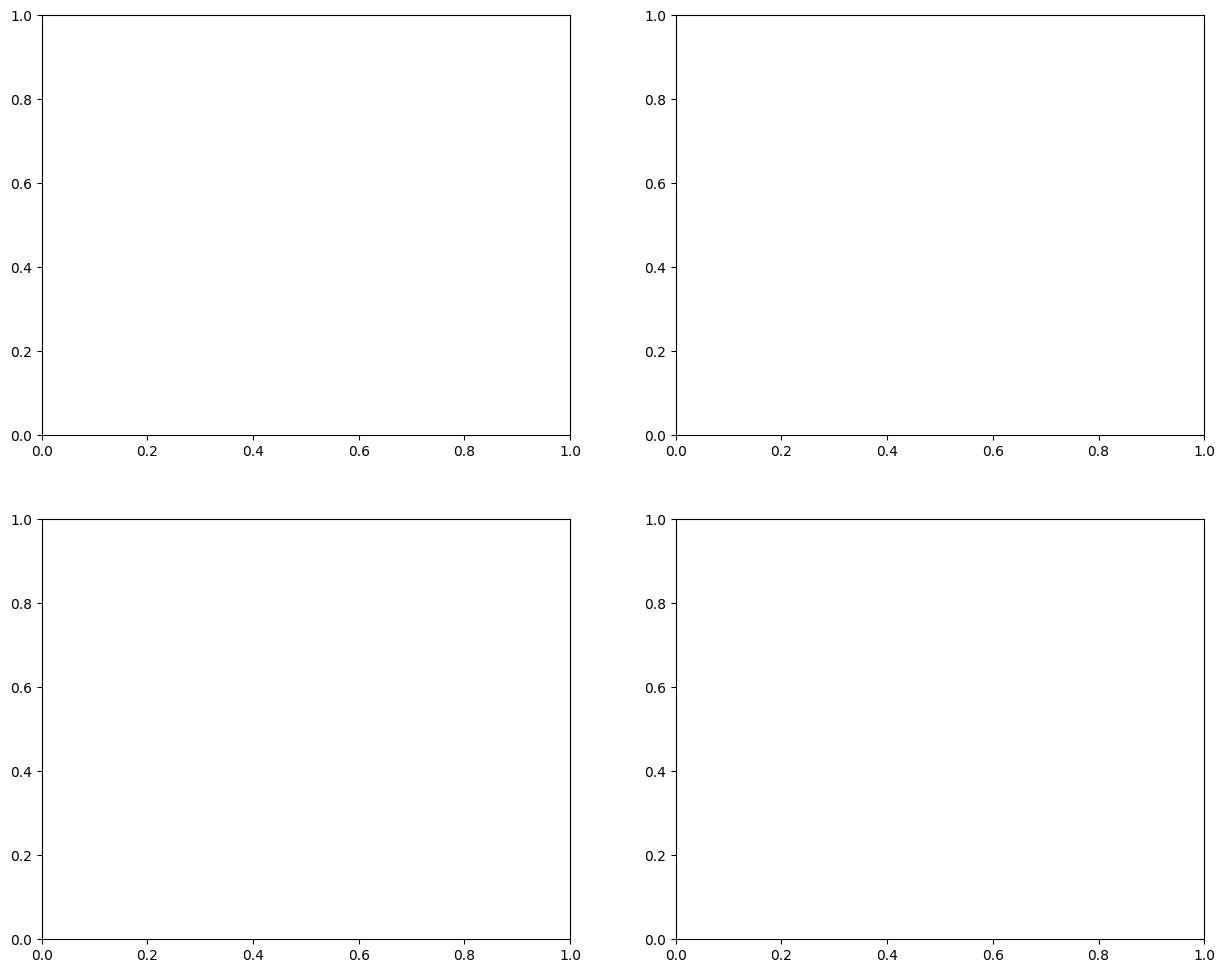

In [ ]:
# Create enhanced visualizations including cost compliance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Extract data for plotting
groups = list(enhanced_results.keys())
process_compliant = [enhanced_results[g]['process_compliant'] for g in groups]
cost_compliant = [enhanced_results[g]['cost_compliant'] for g in groups]
fully_compliant = [enhanced_results[g]['fully_compliant'] for g in groups]
process_non_compliant = [enhanced_results[g]['process_non_compliant'] for g in groups]
cost_non_compliant = [enhanced_results[g]['cost_non_compliant'] for g in groups]

x = range(len(groups))
width = 0.25

# 1. Compliance comparison
axes[0,0].bar([i - width for i in x], process_compliant, width, label='Process Compliant', alpha=0.8)
axes[0,0].bar(x, cost_compliant, width, label='Cost Compliant', alpha=0.8)
axes[0,0].bar([i + width for i in x], fully_compliant, width, label='Fully Compliant', alpha=0.8)
axes[0,0].set_xlabel('Process Groups')
axes[0,0].set_ylabel('Number of Cases')
axes[0,0].set_title('Compliance Comparison: Process vs Cost vs Full')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(groups, rotation=45)
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Compliance rates
process_rates = [enhanced_results[g]['process_compliance_rate'] for g in groups]
cost_rates = [enhanced_results[g]['cost_compliance_rate'] for g in groups]
full_rates = [enhanced_results[g]['full_compliance_rate'] for g in groups]

axes[0,1].bar([i - width for i in x], process_rates, width, label='Process Rate', alpha=0.8)
axes[0,1].bar(x, cost_rates, width, label='Cost Rate', alpha=0.8)
axes[0,1].bar([i + width for i in x], full_rates, width, label='Full Rate', alpha=0.8)
axes[0,1].set_xlabel('Process Groups')
axes[0,1].set_ylabel('Compliance Rate (%)')
axes[0,1].set_title('Compliance Rates by Category')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(groups, rotation=45)
axes[0,1].legend()
axes[0,1].set_ylim(0, 100)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Cost deviation analysis
total_deviations = [enhanced_results[g]['total_cost_deviation'] for g in groups]
avg_deviations = [enhanced_results[g]['average_cost_deviation'] for g in groups]

bars = axes[1,0].bar(groups, total_deviations, alpha=0.7, color='coral')
axes[1,0].set_xlabel('Process Groups')
axes[1,0].set_ylabel('Total Cost Deviation (EUR)')
axes[1,0].set_title('Total Cost Deviations by Process Group')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height,
                   f'€{height:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Cases with cost data
cases_with_costs = [enhanced_results[g]['cases_with_costs'] for g in groups]
total_cases = [enhanced_results[g]['total'] for g in groups]

axes[1,1].bar(groups, total_cases, alpha=0.5, label='Total Cases', color='lightblue')
axes[1,1].bar(groups, cases_with_costs, alpha=0.8, label='Cases with Cost Data', color='darkblue')
axes[1,1].set_xlabel('Process Groups')
axes[1,1].set_ylabel('Number of Cases')
axes[1,1].set_title('Cases with Cost Data Coverage')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("ENHANCED COMPLIANCE SUMMARY")
print("="*70)

total_cases_all = sum(enhanced_results[g]['total'] for g in groups)
total_process_compliant = sum(enhanced_results[g]['process_compliant'] for g in groups)
total_cost_compliant = sum(enhanced_results[g]['cost_compliant'] for g in groups)
total_fully_compliant = sum(enhanced_results[g]['fully_compliant'] for g in groups)
total_cost_deviation = sum(enhanced_results[g]['total_cost_deviation'] for g in groups)

print(f"Overall Statistics across all {len(groups)} process groups:")
print(f"  📊 Total cases analyzed: {total_cases_all:,}")
print(f"  🔄 Process compliance: {total_process_compliant:,} ({total_process_compliant/total_cases_all*100:.2f}%)")
print(f"  💰 Cost compliance: {total_cost_compliant:,} ({total_cost_compliant/total_cases_all*100:.2f}%)")
print(f"  ✅ Full compliance: {total_fully_compliant:,} ({total_fully_compliant/total_cases_all*100:.2f}%)")
print(f"  💸 Total cost deviation: €{total_cost_deviation:,.2f}")

print(f"\nCompliance Gap Analysis:")
process_gap = total_process_compliant - total_fully_compliant
cost_gap = total_cost_compliant - total_fully_compliant
print(f"  📉 Cases failing cost validation: {process_gap:,}")
print(f"  📉 Cases failing process validation: {cost_gap:,}")

# Identify most problematic category
worst_compliance = min(groups, key=lambda g: enhanced_results[g]['full_compliance_rate'])
best_compliance = max(groups, key=lambda g: enhanced_results[g]['full_compliance_rate'])

print(f"\nCategory Analysis:")
print(f"  🚨 Most problematic: {worst_compliance} ({enhanced_results[worst_compliance]['full_compliance_rate']:.2f}% full compliance)")
print(f"  ✅ Best performing: {best_compliance} ({enhanced_results[best_compliance]['full_compliance_rate']:.2f}% full compliance)")

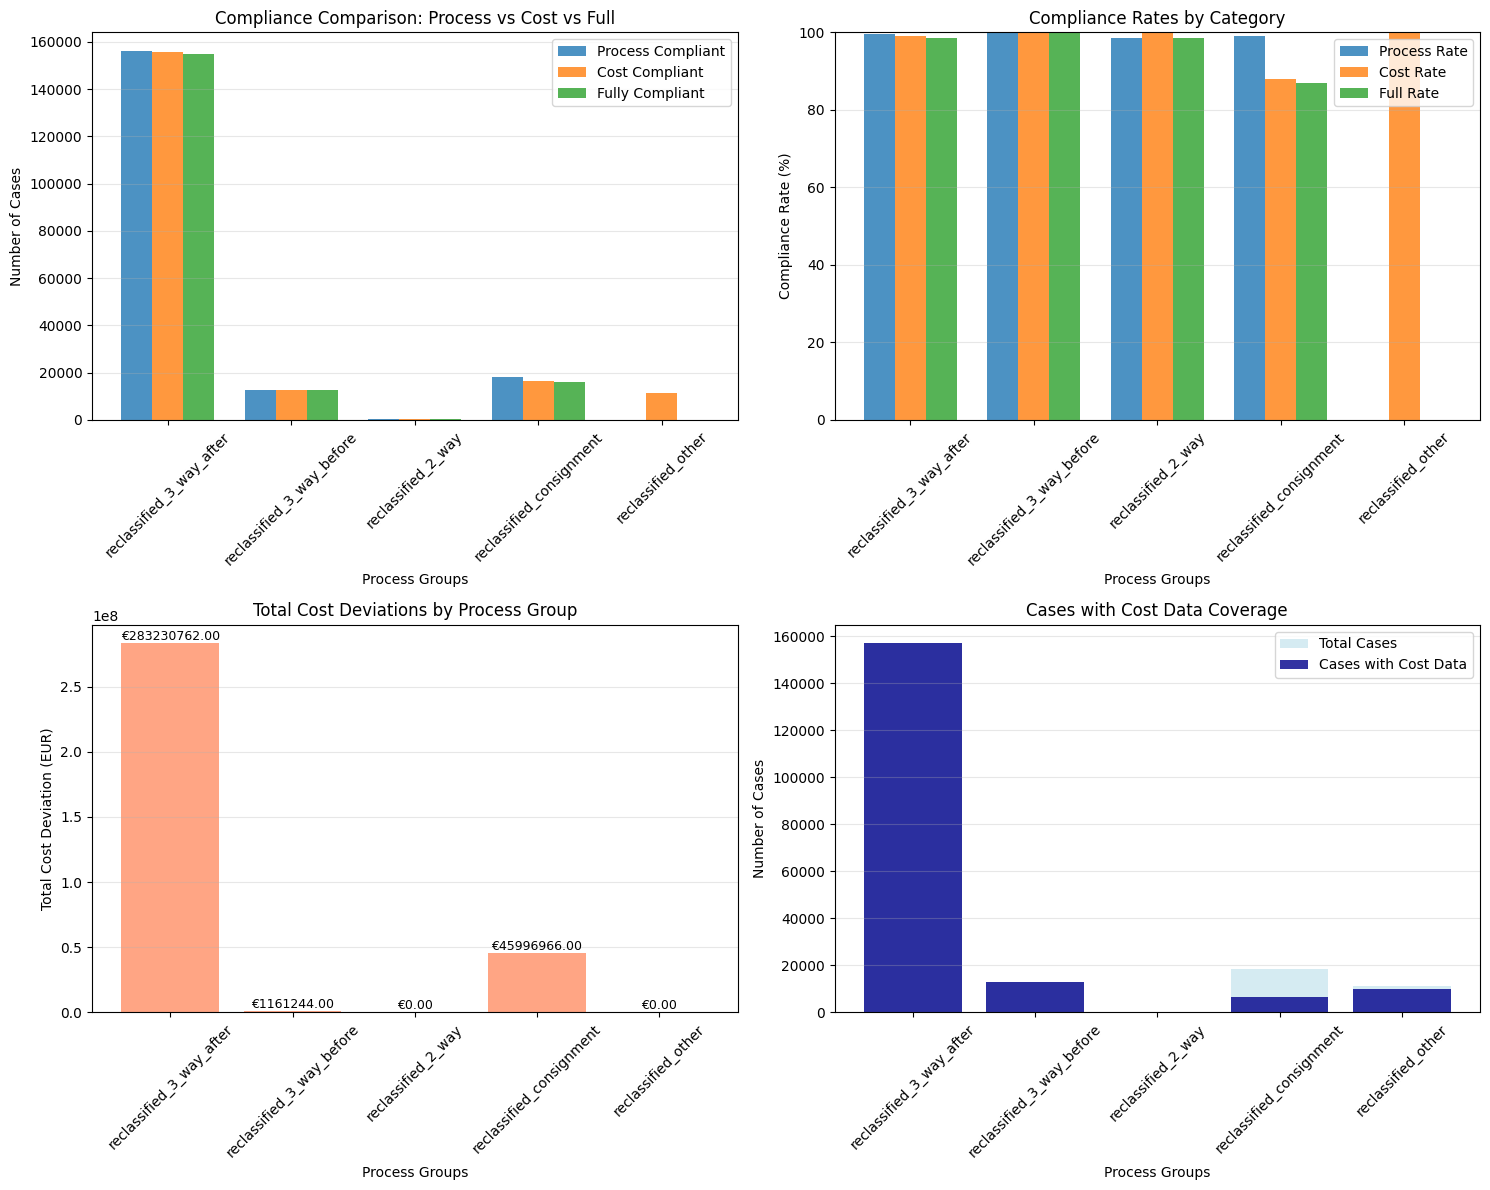


ENHANCED COMPLIANCE SUMMARY
Overall Statistics across all 5 process groups:
  📊 Total cases analyzed: 199,867
  🔄 Process compliance: 187,586 (93.86%)
  💰 Cost compliance: 196,150 (98.14%)
  ✅ Full compliance: 183,869 (92.00%)
  💸 Total cost deviation: €330,388,972.00

Compliance Gap Analysis:
  📉 Cases failing cost validation: 3,717
  📉 Cases failing process validation: 12,281

Category Analysis:
  🚨 Most problematic: reclassified_other (0.00% full compliance)
  ✅ Best performing: reclassified_3_way_before (99.79% full compliance)


In [67]:
# Create enhanced visualizations including cost compliance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Extract data for plotting
groups = list(enhanced_reclassified_results.keys())
process_compliant = [enhanced_reclassified_results[g]['process_compliant'] for g in groups]
cost_compliant = [enhanced_reclassified_results[g]['cost_compliant'] for g in groups]
fully_compliant = [enhanced_reclassified_results[g]['fully_compliant'] for g in groups]
process_non_compliant = [enhanced_reclassified_results[g]['process_non_compliant'] for g in groups]
cost_non_compliant = [enhanced_reclassified_results[g]['cost_non_compliant'] for g in groups]

x = range(len(groups))
width = 0.25

# 1. Compliance comparison
axes[0,0].bar([i - width for i in x], process_compliant, width, label='Process Compliant', alpha=0.8)
axes[0,0].bar(x, cost_compliant, width, label='Cost Compliant', alpha=0.8)
axes[0,0].bar([i + width for i in x], fully_compliant, width, label='Fully Compliant', alpha=0.8)
axes[0,0].set_xlabel('Process Groups')
axes[0,0].set_ylabel('Number of Cases')
axes[0,0].set_title('Compliance Comparison: Process vs Cost vs Full')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(groups, rotation=45)
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Compliance rates
process_rates = [enhanced_reclassified_results[g]['process_compliance_rate'] for g in groups]
cost_rates = [enhanced_reclassified_results[g]['cost_compliance_rate'] for g in groups]
full_rates = [enhanced_reclassified_results[g]['full_compliance_rate'] for g in groups]

axes[0,1].bar([i - width for i in x], process_rates, width, label='Process Rate', alpha=0.8)
axes[0,1].bar(x, cost_rates, width, label='Cost Rate', alpha=0.8)
axes[0,1].bar([i + width for i in x], full_rates, width, label='Full Rate', alpha=0.8)
axes[0,1].set_xlabel('Process Groups')
axes[0,1].set_ylabel('Compliance Rate (%)')
axes[0,1].set_title('Compliance Rates by Category')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(groups, rotation=45)
axes[0,1].legend()
axes[0,1].set_ylim(0, 100)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Cost deviation analysis
total_deviations = [enhanced_reclassified_results[g]['total_cost_deviation'] for g in groups]
avg_deviations = [enhanced_reclassified_results[g]['average_cost_deviation'] for g in groups]

bars = axes[1,0].bar(groups, total_deviations, alpha=0.7, color='coral')
axes[1,0].set_xlabel('Process Groups')
axes[1,0].set_ylabel('Total Cost Deviation (EUR)')
axes[1,0].set_title('Total Cost Deviations by Process Group')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height,
                   f'€{height:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Cases with cost data
cases_with_costs = [enhanced_reclassified_results[g]['cases_with_costs'] for g in groups]
total_cases = [enhanced_reclassified_results[g]['total'] for g in groups]

axes[1,1].bar(groups, total_cases, alpha=0.5, label='Total Cases', color='lightblue')
axes[1,1].bar(groups, cases_with_costs, alpha=0.8, label='Cases with Cost Data', color='darkblue')
axes[1,1].set_xlabel('Process Groups')
axes[1,1].set_ylabel('Number of Cases')
axes[1,1].set_title('Cases with Cost Data Coverage')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("ENHANCED COMPLIANCE SUMMARY")
print("="*70)

total_cases_all = sum(enhanced_reclassified_results[g]['total'] for g in groups)
total_process_compliant = sum(enhanced_reclassified_results[g]['process_compliant'] for g in groups)
total_cost_compliant = sum(enhanced_reclassified_results[g]['cost_compliant'] for g in groups)
total_fully_compliant = sum(enhanced_reclassified_results[g]['fully_compliant'] for g in groups)
total_cost_deviation = sum(enhanced_reclassified_results[g]['total_cost_deviation'] for g in groups)

print(f"Overall Statistics across all {len(groups)} process groups:")
print(f"  📊 Total cases analyzed: {total_cases_all:,}")
print(f"  🔄 Process compliance: {total_process_compliant:,} ({total_process_compliant/total_cases_all*100:.2f}%)")
print(f"  💰 Cost compliance: {total_cost_compliant:,} ({total_cost_compliant/total_cases_all*100:.2f}%)")
print(f"  ✅ Full compliance: {total_fully_compliant:,} ({total_fully_compliant/total_cases_all*100:.2f}%)")
print(f"  💸 Total cost deviation: €{total_cost_deviation:,.2f}")

print(f"\nCompliance Gap Analysis:")
process_gap = total_process_compliant - total_fully_compliant
cost_gap = total_cost_compliant - total_fully_compliant
print(f"  📉 Cases failing cost validation: {process_gap:,}")
print(f"  📉 Cases failing process validation: {cost_gap:,}")

# Identify most problematic category
worst_compliance = min(groups, key=lambda g: enhanced_reclassified_results[g]['full_compliance_rate'])
best_compliance = max(groups, key=lambda g: enhanced_reclassified_results[g]['full_compliance_rate'])

print(f"\nCategory Analysis:")
print(f"  🚨 Most problematic: {worst_compliance} ({enhanced_reclassified_results[worst_compliance]['full_compliance_rate']:.2f}% full compliance)")
print(f"  ✅ Best performing: {best_compliance} ({enhanced_reclassified_results[best_compliance]['full_compliance_rate']:.2f}% full compliance)")